# Chicago West Nile Virus Recommendations
## By Brendan Bailey, Robert Miller, and Robert Watkins

Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Reading in each of the datasets, and performing EDA on them.

Due to the spray dataframe only covering half of our train dataframe, we decided to not use the spray dataframe.

The weather dataframe had a lot of null values. Some of the null values were coded as "M" or "T". So we converted them to nulls.

Another oddity noticed which we cannot fix is that train data only covers every other year.

In [2]:
def eda(dataframe): #Performs exploratory data analysis on the dataframe
    print "columns \n", dataframe.columns
    print "head \n", dataframe.head()
    print "tail \n", dataframe.tail()
    print "missing values \n", dataframe.isnull().sum()
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape
    print "dataframe describe \n", dataframe.describe() #summary statistics
    for item in dataframe:
        print item
        print dataframe[item].nunique()
    print "%s duplicates out of %s records" % (len(dataframe) - len(dataframe.drop_duplicates()), len(dataframe))

In [3]:
train_df = pd.read_csv("assets/train.csv")
weather_df = pd.read_csv("assets/weather.csv")
spray_df = pd.read_csv("assets/spray.csv")

In [4]:
print "Train DF\n", eda(train_df)
print "Weather DF\n", eda(weather_df)
print "Spray DF\n", eda(spray_df)

Train DF
columns 
Index([u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')
head 
         Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   


In addition to correcting the problems seen during EDA, we rolled up the train data set which has multiple records for any date and box that has a mosquito count that exceeds 50, converted all columns to the appropriate data type, and joined the new train dataframe to the weather dataframe.

In [5]:
def clean_and_transform(train, weather):
    #Replacing M which is missing data and T which is Trace Data with NAN
    weather_df.replace("M", np.nan, inplace = True)
    weather_df.replace("T", np.nan, inplace = True)
    
    #Casting all appropriate weather columns as ints
    numeric_columns = ['Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
    for column in numeric_columns:
        weather_df[column] = weather_df[column].apply(pd.to_numeric, errors='coerce')
    
    #Imputing Data for WetBulb and StnPressure
    wetbulb_median = np.median(weather_df.dropna(subset = ["WetBulb"]).WetBulb)
    stnpressure_median = np.median(weather_df.dropna(subset = ["StnPressure"]).StnPressure)
    weather_df.WetBulb.fillna(np.median(wetbulb_median), inplace = True)
    weather_df.StnPressure.fillna(np.median(stnpressure_median), inplace = True)
    
    #Rolling up Data so only one record for date and trap available, and also adding spray location based on Date and Location
    train["Date-Trap"] = train["Date"] + "-" + train["Trap"]
    target_remap_dict = {}
    for index, row in train[["Date-Trap", "WnvPresent", "Species"]].iterrows():
        #Checking for WNV Mosquito Species
        if row["Species"] in ["CULEX PIPIENS/RESTUANS", "CULEX RESTUANS", "CULEX PIPIENS"]:
            wnv_mosquitos = 1
        else:
            wnv_mosquitos = 0
        #Updating Dictionary
        try:
            if target_remap_dict[row["Date-Trap"]]["WnvPresentAdj"] == 0:
                target_remap_dict[row["Date-Trap"]]["WnvPresentAdj"] = row["WnvPresent"]
            if target_remap_dict[row["Date-Trap"]]["WnvMosquito"] == 0:
                target_remap_dict[row["Date-Trap"]]["WnvMosquito"] = wnv_mosquitos
        except KeyError: 
            target_remap_dict[row["Date-Trap"]] = {"WnvPresentAdj": row["WnvPresent"], "WnvMosquito": wnv_mosquitos}
    target_remap_df = pd.DataFrame.from_dict(target_remap_dict, orient = "index")
    
    master_df = train.drop_duplicates(subset = ["Date", "Trap"])
    del master_df['WnvPresent']
    del master_df['Species']
    master_df = pd.merge(master_df, target_remap_df, left_on = "Date-Trap", right_index = True)
    master_df = pd.merge(master_df, weather[weather.Station == 1], left_on = "Date", right_on = "Date", how = "left")
    del master_df["Date-Trap"]
    
    #Getting Block Dummies
    block_dummies = pd.get_dummies(master_df.Block)
    master_df = pd.merge(master_df, block_dummies, left_index = True, right_index = True)
    
    #Converting Date from string to date. The df only has data for odd years which is weird!
    master_df["Date"] = pd.to_datetime(master_df.Date)
    
    return master_df

In [6]:
master_df = clean_and_transform(train_df, weather_df)

In [9]:
master_df.columns

Index([                  u'Date',                u'Address',
                        u'Block',                 u'Street',
                         u'Trap', u'AddressNumberAndStreet',
                     u'Latitude',              u'Longitude',
              u'AddressAccuracy',           u'NumMosquitos',
                  u'WnvMosquito',          u'WnvPresentAdj',
                      u'Station',                   u'Tmax',
                         u'Tmin',                   u'Tavg',
                       u'Depart',               u'DewPoint',
                      u'WetBulb',                   u'Heat',
                         u'Cool',                u'Sunrise',
                       u'Sunset',                u'CodeSum',
                        u'Depth',                 u'Water1',
                     u'SnowFall',            u'PrecipTotal',
                  u'StnPressure',               u'SeaLevel',
                  u'ResultSpeed',              u'ResultDir',
                     u'A

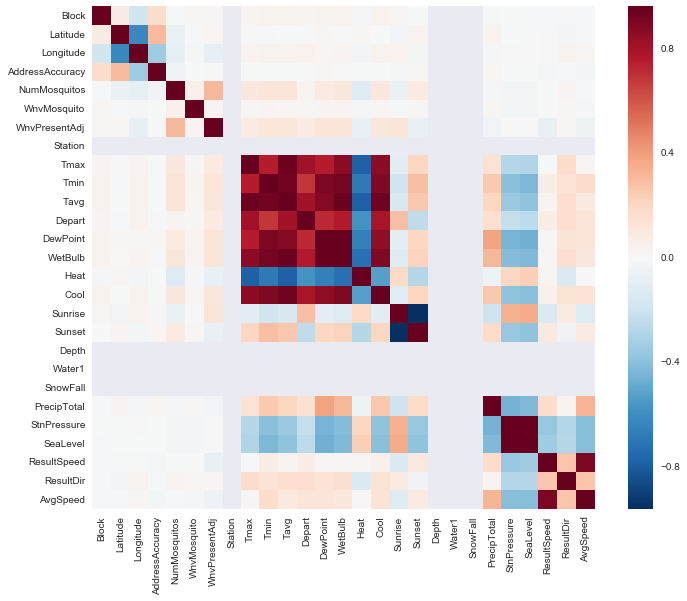

In [10]:
cor =master_df[[u'Date', u'Address', u'Block', u'Street', u'Trap', u'AddressNumberAndStreet', u'Latitude', u'Longitude', u'AddressAccuracy', u'NumMosquitos', u'WnvMosquito', u'WnvPresentAdj', u'Station', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum', u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cor, vmax=.8, square=True)

Here we created our ADABoost Model. We lowered the threshold for predicting a positive to 0.498 to help correct for false negatives.

In our train set we get an accuracy of 80%, sensitivity of 100%, and a specificity of 78%.

In our test set we get an accuracy of 76%, sensitivity of 75%, and a specificity of 76%.

In [11]:
#X = master_df.drop(['WnvPresentAdj', 'CodeSum', 'AddressNumberAndStreet', 'Date', 'Address','Street','Trap','Water1','PrecipTotal', 'SnowFall', 'Block', 96, 93, 98, "NumMosquitos"], axis=1)#[['NumMosquitos', 'Cool', 'DewPoint', 'Sunrise','Heat', 'Tmax', 'Depart', 'WetBulb']]
#X_scaled = preprocessing.normalize(X,axis=0)
X = master_df[["Block", "Tmax", "Tmin", "Tavg", "Depart", "DewPoint", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "StnPressure", "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed"]]
y = master_df.WnvPresentAdj
names = ['has westnile', "doesn't have westnile", "pred westnile", "predicted doesnt have westnile"]

In [12]:
def create_model(model, X_scaled,y,names):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, train_size=.7, random_state = 626718) 
    model.fit(X_train, y_train)
    
    #Train Set Evaluation
    train_predictions = model.predict_proba(X_train)
    train_adjusted_predict = [1 if x[1] > .48 else 0 for x in train_predictions]
    train_conmat = np.array(confusion_matrix(y_train, train_adjusted_predict, labels = [1,0]))
    train_confusion = pd.DataFrame(train_conmat, index=[names[0:2]], columns =[names[2:]])
    print "Train Eval"
    print train_confusion
    train_acc = accuracy_score(y_train, train_adjusted_predict)
    print(classification_report(y_train, train_adjusted_predict))
    print train_acc
    
    #Test Set Evaluation
    test_predictions = model.predict_proba(X_test)
    test_adjusted_predict = [1 if x[1] > .48 else 0 for x in test_predictions]
    test_conmat = np.array(confusion_matrix(y_test, test_adjusted_predict, labels = [1,0]))
    test_confusion = pd.DataFrame(test_conmat, index=[names[0:2]], columns =[names[2:]])
    print "Test Eval"
    print test_confusion
    test_acc = accuracy_score(y_test, test_adjusted_predict)
    print(classification_report(y_test, test_adjusted_predict))
    print test_acc
    
    return model

In [13]:
forest = RandomForestClassifier(random_state = 98574, n_estimators = 50, max_depth = 5, max_features = 0.5)

In [14]:
model = create_model(AdaBoostClassifier(forest, n_estimators = 100, random_state = 918064), X, y, names)

Train Eval
                       pred westnile  predicted doesnt have westnile
has westnile                     269                               0
doesn't have westnile            645                            2317
             precision    recall  f1-score   support

          0       1.00      0.78      0.88      2962
          1       0.29      1.00      0.45       269

avg / total       0.94      0.80      0.84      3231

0.800371402043
Test Eval
                       pred westnile  predicted doesnt have westnile
has westnile                      87                              29
doesn't have westnile            305                             964
             precision    recall  f1-score   support

          0       0.97      0.76      0.85      1269
          1       0.22      0.75      0.34       116

avg / total       0.91      0.76      0.81      1385

0.758844765343


Now apply the model to our test set.

In [15]:
test_df = pd.read_csv("assets/test.csv.zip")

Adjusting our initial clean and transform function which rolls up dates and traps into one record each. We want to have the same number of predictions equal to test set size, so we're deleting that functionality.

In [16]:
def clean_and_transform_final(train, weather):
    #Replacing M which is missing data and T which is Trace Data with NAN
    weather_df.replace("M", np.nan, inplace = True)
    weather_df.replace("T", np.nan, inplace = True)
    
    #Casting all appropriate weather columns as ints
    numeric_columns = ['Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
    for column in numeric_columns:
        weather_df[column] = weather_df[column].apply(pd.to_numeric, errors='coerce')
    
    #Imputing Data for WetBulb and StnPressure
    wetbulb_median = np.median(weather_df.dropna(subset = ["WetBulb"]).WetBulb)
    stnpressure_median = np.median(weather_df.dropna(subset = ["StnPressure"]).StnPressure)
    weather_df.WetBulb.fillna(np.median(wetbulb_median), inplace = True)
    weather_df.StnPressure.fillna(np.median(stnpressure_median), inplace = True)
    
    #Rolling up Data so only one record for date and trap available, and also adding spray location based on Date and Location
    train["Date-Trap"] = train["Date"] + "-" + train["Trap"]
    target_remap_dict = {}
    for index, row in train[["Date-Trap", "Species"]].iterrows():
        #Checking for WNV Mosquito Species
        if row["Species"] in ["CULEX PIPIENS/RESTUANS", "CULEX RESTUANS", "CULEX PIPIENS"]:
            wnv_mosquitos = 1
        else:
            wnv_mosquitos = 0
        #Updating Dictionary
        try:
            if target_remap_dict[row["Date-Trap"]]["WnvMosquito"] == 0:
                target_remap_dict[row["Date-Trap"]]["WnvMosquito"] = wnv_mosquitos
        except KeyError: 
            target_remap_dict[row["Date-Trap"]] = {"WnvMosquito": wnv_mosquitos}
    target_remap_df = pd.DataFrame.from_dict(target_remap_dict, orient = "index")
    
    master_df = pd.merge(test_df, target_remap_df, left_on = "Date-Trap", right_index = True)
    master_df = pd.merge(master_df, weather[weather.Station == 1], left_on = "Date", right_on = "Date", how = "left")
    del master_df['Species']
    del master_df["Date-Trap"]
    
    #Getting Block Dummies
    block_dummies = pd.get_dummies(master_df.Block)
    master_df = pd.merge(master_df, block_dummies, left_index = True, right_index = True)
    
    #Converting Date from string to date. The df only has data for odd years which is weird!
    master_df["Date"] = pd.to_datetime(master_df.Date)
    
    return master_df

In [17]:
master_test = clean_and_transform_final(test_df, weather_df)

In [18]:
X_final = master_test[X.columns]

In the end we predict 9,467 records out of 116,293 are predicted to have West Nile virus.

In [19]:
final_predictions = model.predict_proba(X_final)
final_adjusted_predict = [1 if x[1] > .48 else 0 for x in final_predictions]
print "%s records out of %s predicted to have West Nile" % (sum(final_adjusted_predict), len(final_adjusted_predict))

9467 records out of 116293 predicted to have West Nile


Below saving the results into a csv.

In [20]:
final_adjusted_predict_df = pd.DataFrame(final_adjusted_predict, columns = ["Predictions"])

In [21]:
master_test_csv = pd.merge(master_test, final_adjusted_predict_df, left_index = True, right_index = True)

In [22]:
master_test_csv.to_csv("final_test_set.csv")

In [23]:
kaggle_submission = master_test_csv["Predictions"].to_frame()
kaggle_submission.columns = ["WnvPresent"]
kaggle_submission.index = np.arange(1, len(kaggle_submission) + 1)
kaggle_submission.index.name = "Id"

In [24]:
kaggle_submission.to_csv("kaggle_submission.csv")

Bar Chart of Feature Importances

In [25]:
feature_importances = pd.DataFrame([[x, y] for x, y in zip(X.columns, model.feature_importances_)], columns = ["Variable", "Importance"]).sort_values("Importance", ascending = False).head(10)

In [26]:
plt.style.use('ggplot')

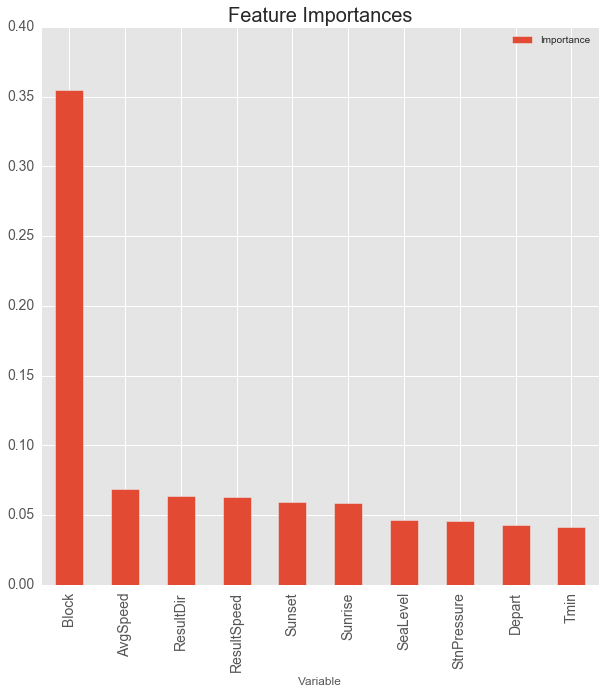

In [27]:
feature_importances.plot(kind = "bar", x = feature_importances.Variable, figsize = (10,10), fontsize = 14)
plt.title("Feature Importances", fontsize = 20)

In [28]:
plt.savefig("featureimportance.png")